# Association Analysis

The object of this notebook is to begin an association analysis to see how the actors, directors and writers affected the user score, critic score, box office (US and global) and IMDB votes the movie had earned.

### Modules We'll Be Using

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
import sklearn
import math
import re
import time
import glob
import json
from mlxtend.frequent_patterns import apriori
import matplotlib.pyplot as plt

plt.style.use('ggplot')

### Pre-processing the Movies CSV

First Let's read in our data and convert the values we care about up front:

In [2]:
# First Read it in
movies_df = pd.read_csv('IMDb movies.csv')

# Rename Columns and convert data types where appropriate
movies_df = movies_df.astype(
    {
     'duration' : 'float',
     'avg_vote' : 'float',
     'votes' : 'float',
#      'budget' : 'float', # Need this to replace '$ \d+' with float(\d+)
#      'usa_gross_income' : 'float', # Need this to replace '$ \d+' with float(\d+)
#      'worlwide_gross_income' : 'float', # Need this to replace '$ \d+' with float(\d+)
     'metascore' : 'float',
     'reviews_from_users' : 'float',
     'reviews_from_critics' : 'float'
    }).rename(columns=
    {'imdb_title_id' : 'title_id',
     'reviews_from_users' : 'user_reviews',
     'reviews_from_critics' : 'critic_reviews',
     'worlwide_gross_income' : 'ww_gross_income'
    })

movies_df = movies_df.set_index(movies_df['title_id']).rename(columns={'title_id' : 'REMOVE'}).drop(columns=['REMOVE'])

# Found a bad row that didn't contain an int for a year (or a year formatted as such)
movies_df = movies_df.drop(index=['tt8206668'], axis=1)
movies_df = movies_df.astype({'year' : 'int'})

# We also don't want any older films to keep the data relatively current
movies_df = movies_df[movies_df['year'] > 1969]

# Only consider films with over 10000 votes
movies_df = movies_df[movies_df['votes'] >= 1000]

# Drop Columns that are not connected to the score or persons involved
movies_df = movies_df.drop(columns=[
    'original_title', 'year', 'title', 'genre',
    'country', 'language', 'date_published', 'duration',
    'description', 'budget', 'votes', 'user_reviews',
    'critic_reviews'])

# Now print a quick summary
print(f'Shape: {movies_df.shape} \n{movies_df.columns}')
movies_df.head(3)

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Shape: (25221, 8) 
Index(['director', 'writer', 'production_company', 'actors', 'avg_vote',
       'usa_gross_income', 'ww_gross_income', 'metascore'],
      dtype='object')


,director,writer,production_company,actors,avg_vote,usa_gross_income,ww_gross_income,metascore
title_id,,,,,,,,
tt0035423,James Mangold,"Steven Rogers, James Mangold",Konrad Pictures,"Meg Ryan, Hugh Jackman, Liev Schreiber, Brecki...",6.4,$ 47121859,$ 76019048,44.0
tt0054724,Del Tenney,Del Tenney,Iselin-Tenney Productions Inc.,"William Joyce, Heather Hewitt, Walter Coy, Dan...",3.5,NaN,NaN,NaN
tt0062690,José Mojica Marins,"Rubens F. Lucchetti, José Mojica Marins",Fotocena Filmes,"José Mojica Marins, Ângelo Assunção, Ronaldo B...",6.1,NaN,NaN,NaN


#### To reduce runtimes, let's separate the data by the main scoring systems: Average Vote, Gross Incomes (US and World) and Metascore

In [3]:
AvgScore_Based = movies_df.dropna(subset=['avg_vote']).drop(columns=['metascore', 'usa_gross_income', 'ww_gross_income'])
print(f'Shape: {AvgScore_Based.shape} \n{AvgScore_Based.columns}')

Shape: (25221, 5) 
Index(['director', 'writer', 'production_company', 'actors', 'avg_vote'], dtype='object')


In [4]:
US_Incomes_Based = movies_df.dropna(subset=['usa_gross_income']).drop(columns=['metascore', 'avg_vote', 'ww_gross_income'])
print(f'Shape: {US_Incomes_Based.shape} \n{US_Incomes_Based.columns}')

Shape: (11979, 5) 
Index(['director', 'writer', 'production_company', 'actors',
       'usa_gross_income'],
      dtype='object')


In [5]:
WW_Incomes_Based = movies_df.dropna(subset=['ww_gross_income']).drop(columns=['metascore', 'avg_vote', 'usa_gross_income'])
print(f'Shape: {WW_Incomes_Based.shape} \n{WW_Incomes_Based.columns}')

Shape: (17719, 5) 
Index(['director', 'writer', 'production_company', 'actors',
       'ww_gross_income'],
      dtype='object')


In [6]:
MetaScore_Based = movies_df.dropna(subset=['metascore']).drop(columns=['avg_vote', 'usa_gross_income', 'ww_gross_income'])
print(f'Shape: {MetaScore_Based.shape} \n{MetaScore_Based.columns}')
MetaScore_Based.head(3)

Shape: (11071, 5) 
Index(['director', 'writer', 'production_company', 'actors', 'metascore'], dtype='object')


,director,writer,production_company,actors,metascore
title_id,,,,,
tt0035423,James Mangold,"Steven Rogers, James Mangold",Konrad Pictures,"Meg Ryan, Hugh Jackman, Liev Schreiber, Brecki...",44.0
tt0064437,"Leonard Kastle, Donald Volkman",Leonard Kastle,Roxanne,"Shirley Stoler, Tony Lo Bianco, Mary Jane Higb...",82.0
tt0065134,Don Siegel,"Budd Boetticher, Albert Maltz",Universal Pictures,"Shirley MacLaine, Clint Eastwood, Manolo Fábre...",62.0


Now we can create our market baskets from the movies summary we just built.  The transaaction ID in these baskets will still be the 'title_id', and we'll keep the respective scores, dollar values, dates, etc. intact.  We will create one for each seperate category of interest and one for all of them together.  Let's first start with the separate ones

### Helper Functions

##### The ones for the Market Basket

In [7]:
# Helper function to create a market basket out of a given dataframe, column and delimiter
def make_marketbasket_from_list(df, colname, delimiter):
    starttime = time.time()
    basket_df = df[colname].astype('object')
    itemlist = []
    
    # First get the list of items that'll constitute our columns
    for trans_id in basket_df.index:
        itemset = re.split(delimiter, basket_df[trans_id])

        for item in itemset:
            if (item.lower() not in itemlist):
                itemlist.append(item.lower())

    print(f'Item Count: {len(itemlist)}')

    # Now make the transactions by creating an np.array of boolean values
    itemtrans = []
    
    for trans_id in basket_df.index:
        trans = []
        
        if (math.floor(len(itemtrans) % (df.count().max() / 10)) == 0):
            print(f'{len(itemtrans)}/{df.count().max()}, Runtime: {time.time() - starttime}sec')
            starttime = time.time()

        for i in range(len(itemlist)):
            trans.append(bool(
                re.match(
                    re.compile(f'{itemlist[i]}'),
                    basket_df[trans_id].lower()
                )
            ))
        
        itemtrans.append(trans)
    
    itemtrans = np.array(itemtrans)
    print(f'Basket Shape: {itemtrans.shape}')
    
    # Finally, return the market basket!
    return(pd.DataFrame(index=df.index, columns=itemlist, data=itemtrans))

# Helper function to make interval market basket data
def make_marketbasket_from_interval(df, colname, lowend, highend, step):
    starttime = time.time()
    basket_df = df[colname]
    lowend = float(lowend)
    highend = float(highend)
    step = float(step)
    dividers = np.arange(lowend, highend + 1, step)
    
    # Make the baskets
    basket = [f'{colname} < {lowend}']
    
    for i in range(len(dividers) - 1):
        basket.append(f'{colname} in [{dividers[i]}, {dividers[i + 1]})')
    
    basket.append(f'{colname} >= {highend}')
    print(f'Discretized Basket: {basket}')

    # Now make the transactions
    itemtrans = []

    for tid in basket_df.index:
        if (math.floor(len(itemtrans) % (df.count().max() / 10)) == 0):
            print(f'{len(itemtrans)}/{df.count().max()}, Runtime: {time.time() - starttime}sec')
            starttime = time.time()

        trans = [bool(lowend > basket_df[tid])]

        for i in range(len(dividers) - 1):
            trans.append(
                bool((dividers[i] <= basket_df[tid]) and (dividers[i + 1] > basket_df[tid]))
            )
        
        trans.append(bool(highend <= basket_df[tid]))
        itemtrans.append(trans)

    itemtrans = np.array(itemtrans)
    print(f'Transaction Shape: {itemtrans.shape}')
    
    # Finally, return the market basket!
    return(pd.DataFrame(index=df.index, columns=basket, data=itemtrans))

# Helper function to substitute a column with its market basket
def convert_to_marketbasket_list(df, col_basket, delim):
    marketbasket = make_marketbasket_from_list(df, col_basket, delim)
    
    return(df.merge(marketbasket, how='outer', left_index=True, right_index=True).drop(columns=[col_basket]))

# Helper function that substitutes column with interval market basket
def convert_to_marketbasket_interval(df, col_basket, lowend, highend, step):
    marketbasket = make_marketbasket_from_interval(df, col_basket, lowend, highend, step)
    
    return(df.merge(marketbasket, how='outer', left_index=True, right_index=True).drop(columns=[col_basket]))

#### Now for the ones sourced in the prior individual project

In [8]:
# Returns frequency counts for items and item pairs
def freq(iterable):
    if type(iterable) == pd.core.series.Series:
        return iterable.value_counts().rename("freq")
    else: 
        return pd.Series(order_count(iterable)).rename("freq")

    
# Returns number of unique orders
def order_count(order_item):
    return len(set(order_item.index))


# Returns generator that yields item pairs, one at a time
def get_item_pairs(order_item):
    order_item = order_item.reset_index().to_numpy()
    for order_id, order_object in groupby(order_item, lambda x: x[0]):
        item_list = [item[1] for item in order_object]
              
        for item_pair in combinations(item_list, 2):
            yield item_pair
            

# Returns frequency and support associated with item
def merge_item_stats(item_pairs, item_stats):
    return (item_pairs
                .merge(item_stats.rename(columns={'freq': 'freqA', 'support': 'supportA'}), left_on='item_A', right_index=True)
                .merge(item_stats.rename(columns={'freq': 'freqB', 'support': 'supportB'}), left_on='item_B', right_index=True))


# Returns name associated with item
def merge_item_name(rules, item_name):
    columns = ['itemA','itemB','freqAB','supportAB','freqA','supportA','freqB','supportB', 
               'confidenceAtoB','confidenceBtoA','lift']
    rules = (rules
                .merge(item_name.rename(columns={'item_name': 'itemA'}), left_on='item_A', right_on='item_id')
                .merge(item_name.rename(columns={'item_name': 'itemB'}), left_on='item_B', right_on='item_id'))
    return rules[columns]               

In [9]:
def association_rules(order_item, min_support):

    print("Starting order_item: {:22d}".format(len(order_item)))


    # Calculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Filter from order_item items below min support 
    qualifying_items       = item_stats[item_stats['support'] >= min_support].index
    order_item             = order_item[order_item.isin(qualifying_items)]

    print("Items with support >= {}: {:15d}".format(min_support, len(qualifying_items)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Filter from order_item orders with less than 2 items
    order_size             = freq(order_item.index)
    qualifying_orders      = order_size[order_size >= 2].index
    order_item             = order_item[order_item.index.isin(qualifying_orders)]

    print("Remaining orders with 2+ items: {:11d}".format(len(qualifying_orders)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Recalculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Get item pairs generator
    item_pair_gen          = get_item_pairs(order_item)


    # Calculate item pair frequency and support
    item_pairs              = freq(item_pair_gen).to_frame("freqAB")
    item_pairs['supportAB'] = item_pairs['freqAB'] / len(qualifying_orders) * 100

    print("Item pairs: {:31d}".format(len(item_pairs)))


    # Filter from item_pairs those below min support
    item_pairs              = item_pairs[item_pairs['supportAB'] >= min_support]

    print("Item pairs with support >= {}: {:10d}\n".format(min_support, len(item_pairs)))


    # Create table of association rules and compute relevant metrics
    item_pairs = item_pairs.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B'})
    item_pairs = merge_item_stats(item_pairs, item_stats)
    
    item_pairs['confidenceAtoB'] = item_pairs['supportAB'] / item_pairs['supportA']
    item_pairs['confidenceBtoA'] = item_pairs['supportAB'] / item_pairs['supportB']
    item_pairs['lift']           = item_pairs['supportAB'] / (item_pairs['supportA'] * item_pairs['supportB'])
    
    
    # Return association rules sorted by lift in descending order
    return item_pairs.sort_values('lift', ascending=False)

### Apriori with Actors

In [10]:
# Sensibly, let's stick with only those above average Metascores
print(f"Mean:  {MetaScore_Based['metascore'].mean()}")
MetaScore_Based = MetaScore_Based[MetaScore_Based['metascore'] > MetaScore_Based['metascore'].mean()]
print(f"Shape: {MetaScore_Based.shape}")
MetaScore_Based.head(4)

Mean:  55.56255080841839
Shape: (5734, 5)


,director,writer,production_company,actors,metascore
title_id,,,,,
tt0064437,"Leonard Kastle, Donald Volkman",Leonard Kastle,Roxanne,"Shirley Stoler, Tony Lo Bianco, Mary Jane Higb...",82.0
tt0065134,Don Siegel,"Budd Boetticher, Albert Maltz",Universal Pictures,"Shirley MacLaine, Clint Eastwood, Manolo Fábre...",62.0
tt0065421,Wolfgang Reitherman,"Larry Clemmons, Vance Gerry",Walt Disney Animation Studios,"Phil Harris, Eva Gabor, Sterling Holloway, Sca...",66.0
tt0065466,Russ Meyer,"Roger Ebert, Roger Ebert",Twentieth Century Fox,"Dolly Read, Cynthia Myers, Marcia McBroom, Joh...",60.0


In [11]:
actor_only_df = convert_to_marketbasket_list(MetaScore_Based.dropna(subset=['actors']).drop(columns=['writer', 'director', 'production_company']), 'actors', ', ')
actor_only_df.to_csv('market-baskets\Metascore-actor-basket.csv')
# actor_only_df = pd.read_csv('market-baskets\Metascore-actor-basket.csv')
actor_only_df.head(4)

Item Count: 49899
0/5731, Runtime: 19.937689781188965sec
574/5731, Runtime: 1887.453471660614sec
1147/5731, Runtime: 1962.4805393218994sec
1720/5731, Runtime: 1780.1055483818054sec
2293/5731, Runtime: 1703.5268549919128sec
2866/5731, Runtime: 1706.837604045868sec
3439/5731, Runtime: 1680.9787063598633sec
4012/5731, Runtime: 1701.186957359314sec
4585/5731, Runtime: 1727.0804269313812sec
5158/5731, Runtime: 1720.6124103069305sec
Basket Shape: (5731, 49899)


,metascore,shirley stoler,tony lo bianco,mary jane higby,doris roberts,kip mcardle,marilyn chris,dortha duckworth,barbara cason,ann harris,...,jocelyn veluire,ramon pujol,mariano lopez seoane,helen celia castro-wood,tom williamson,travis hammer,dora madison,josh ethier,linnea wilson,jesse kove
title_id,,,,,,,,,,,,,,,,,,,,,
tt0064437,82.0,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
tt0065134,62.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
tt0065421,66.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
tt0065466,60.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


#### Lets See what they yield

In [28]:
# Apriori results
print(actor_only_df.drop(columns=['metascore']).shape)
frequent_itemsets = apriori(actor_only_df.drop(columns=['metascore']), min_support = 0.003, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

(5731, 49899)


,support,itemsets,length
0,0.004188,(clint eastwood),1
1,0.003839,(robert de niro),1
2,0.003315,(al pacino),1
3,0.003490,(tom cruise),1
4,0.003839,(leon),1
5,0.004188,(tom hanks),1
6,0.003141,(denzel washington),1
7,0.004013,(ali),1
8,0.005409,(sean),1
9,0.006631,(ant),1


Note that when the threshold % is 0.03% that no pairs appear.  This means any association analysis on the cast is going to prove insignificant in the broader creation of films.

[]

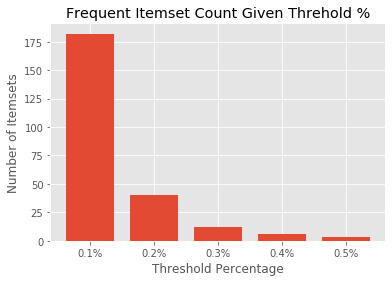

In [25]:
itemsets = []
itemsetcounts = []
thresholds = [0.001, 0.002, 0.003, 0.004, 0.005]
thresholds_str = ['0.1%', '0.2%', '0.3%', '0.4%', '0.5%']

for i in thresholds:
    itemsets.append(apriori(actor_only_df.drop(columns=['metascore']), min_support=i, use_colnames=True))

for i in itemsets:
    itemsetcounts.append(i.count().min())

fig, ax = plt.subplots()
bar1 = plt.bar(thresholds_str, itemsetcounts, width=0.75)
plt.xticks(np.arange(11), thresholds_str)
plt.title('Frequent Itemset Count Given Threhold %')
ax.set_ylabel('Number of Itemsets')
ax.set_xlabel('Threshold Percentage')
plt.plot()

The graph above illustrates how low the frequency of the actors is for all of the movies released since 1970 where the vote count on IMDB was over 1000.  Given we are analyzing thousands of movies, this attribute is not signfiicant across the years we are interested in.

### Switching to Clustering At This Point
The work so far has made it clear that the runtimes and association analysis attempts will not provide any mmeaningful information for us to use.  Determining which attributes can be converted to numeric scales and maintain their value to the dataset might prove more useful at this point. 